In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra.datasets
from cebra import CEBRA
from PIL import Image
import cv2
import torch
import pickle

/media/murphy/CEBRA_project/.venv/lib/python3.9/site-packages/cebra/datasets/__init__.py:92: UserWarning: Could not initialize one or more datasets: No module named 'h5py'. For using the datasets, consider installing the [datasets] extension via pip.
  warnings.warn(f"Could not initialize one or more datasets: {e}. "


In [2]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
print(DEVICE)

cpu


In [13]:
from logging import exception
def process_brain(path):
  try:
    brain_seq = cv2.imreadmulti(path)[1]
    brain_seq = np.array(brain_seq)
    brain_mask = (np.sum(brain_seq, axis=0) > 0)
    flat_seq = (brain_seq[:, brain_mask])
    return flat_seq.astype(float)
  except:
    print(np.shape(brain_seq))


In [18]:
# iterate through all data and process it
#https://stackoverflow.com/questions/10377998/how-can-i-iterate-over-files-in-a-given-directory
import os
neural_data = []
name_data = []
behav_data = []

filepath = "2020_11_9_MV1_run_brain"
for file in os.listdir(filepath):
     filename = os.fsdecode(file)
     if filename.endswith(".tif"):
         neural_data.append(process_brain(filepath + '/' + filename))
         name_data.append(filename)
         split_name = filename.split('_')
         session_data = []
         session_data.append(int(split_name[2].split('.')[0]))
         session_data.append(int(split_name[1]))
         behav_data.append(session_data)
         continue
     else:
         continue

In [19]:
max_iterations = 10
cebra_time_model = CEBRA(model_architecture='offset10-model',
                        batch_size=128,
                        learning_rate=1e-3,
                        temperature_mode = 'auto',
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10,
                        )

In [17]:
#generate mock behavioural data for time only run
mock_behav = []
for count, data in enumerate(neural_data):
    mock_behav.append(np.ones_like(data[:, 0]) * count)

In [20]:
test_dataset = {'neural':neural_data, 'y':mock_behav}
with open('mypickle.pickle', 'wb') as f:
    pickle.dump(test_dataset, f)


In [22]:
neural_data_loaded = cebra.load_data(file="mypickle.pickle", key="neural")
continuous_label = cebra.load_data(file="mypickle.pickle", key="y")

OSError: File ending .pickle not supported.

In [29]:
multi_cebra_model = cebra.CEBRA(batch_size=128,
                                output_dimension=out_dim,
                                max_iterations=10,
                                max_adapt_iterations=10)

In [31]:
multi_cebra_model.fit(neural_data, mock_behav)

In [60]:
print(np.shape(mock_behav[1]))
np.shape(neural_data[1])

(132,)


(132, 10634)

<Axes3D: title={'center': 'Embedding'}>

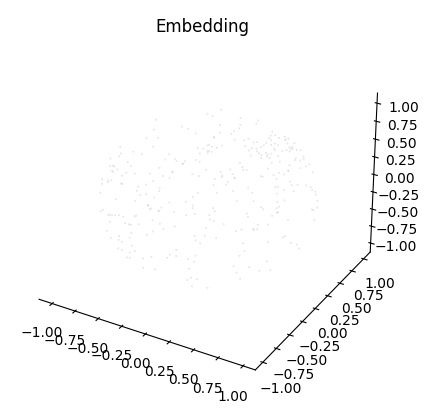

In [64]:
embedding = cebra_time_model.transform(neural_data[2])
cebra.plot_embedding(embedding)